# Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from rdkit import Chem
import rdkit.Chem.PandasTools as PandasTools
from rdkit.Chem import QED
from rdkit.Chem import AllChem

PandasTools.InstallPandasTools()

In [4]:
from IPython.display import HTML

In [5]:
from scipy.spatial import distance

In [6]:
import os
from collections import defaultdict

### Analysis Variables

In [7]:
blob="lig_gen"

Maximum RMSD threshold used for filtering molecules with low RMSD between generated and minimised structure:

In [8]:
maxRMSD = 1.0

Minimum QED threshold used for filtering:

In [9]:
minQED = 0.8

Suffixes of RMSD files:

In [10]:
rmsdtypes = ["uff", "vina"]

In [11]:
maxVina = -7

In [12]:
minCNNscore = 0.7

### Helper Functions

TODO: Extract such functions in a Python module.

In [13]:
def root_and_prefix(datafile):
    """
    Root directory and prefix.
    """
    dataroot = os.path.dirname(datafile)
    prefix, _ = os.path.splitext(os.path.basename(datafile))
    
    return dataroot, prefix

In [14]:
def load_rmsd(dataroot, prefix, df):
    """
    Load ligand RMSD CSV files and add RMSD to DataFrame
    """
    ligands = df["lig_name"].unique()

    # Load RMSDs
    for ligand in ligands:
        for rmsdtype in rmsdtypes:
            fname = os.path.join(dataroot, prefix + "_" + ligand + f"_{blob}_RMSD{rmsdtype}.csv")
            df_rmsd = pd.read_csv(fname)
    
            # Assign ligand RMSD to general dataset
            # Assumes sample indices are in the same order (but indices might be missing from RMSD dataframe)
            df.loc[(df["sample_idx"].isin(df_rmsd["sample"])) & (df["lig_name"] == ligand), f"rmsd_{rmsdtype}"] =  \
                df_rmsd["rmsd"].to_numpy()

    # Drop all samples for which the RMSD between generated and minimised structures 
    # could not be computed (reconstruction failed):
    nall = len(df)
    df.dropna(subset=[f"rmsd_{rt}" for rt in rmsdtypes], inplace=True)
    
    print(f"Successfully reconstructed molecules: {len(df) / nall * 100:.2f}%")

In [15]:
def load_scores(dataroot, prefix, df):
    ligands = df["lig_name"].unique()
    
    for ligand in ligands:
        fname = os.path.join(dataroot, prefix + "_" + ligand + f"_{blob}_scores.csv")
        df_scores = pd.read_csv(fname)
        
        # Assign scores to general dataset
        # Assumes sample indices are in the same order (but indices might be missing from RMSD dataframe)
        scores = ["vinaaffinity", "cnnscore", "cnnaffinity"]
        df.loc[(df["sample_idx"].isin(df_scores["sample"])) & (df["lig_name"] == ligand), scores] =  \
                df_scores[scores].to_numpy()

In [16]:
def rmsd_statistics(df, mRMSD):
    
    for rt in rmsdtypes:
        rmsd = df[f"rmsd_{rt}"].to_numpy()        
        
        print(f"--- {rt.upper()} ---")
        print(f"Average RMSD: {np.mean(rmsd)}")
        print(f"Median RMSD: {np.median(rmsd)}")
        print(f"Percentage of low-RMSD samples: {np.logical_and(rmsd < mRMSD, rmsd > 0.05).sum() / len(rmsd)  * 100}%")

In [17]:
def filter(df, mRMSD, mQED):
    # Some systems have 0.0 RMSD
    df_lowrmsd = df[(df.rmsd_vina < mRMSD) & (df.rmsd_vina > 0.05)].copy()
    
    # Sort by RMSD, so that fropping duplicates will retain lowest RMSD
    df_lowrmsd.sort_values(by="rmsd_vina", ascending=True, inplace=True)
    df_lowrmsd = df_lowrmsd.drop_duplicates(subset=[f"{blob}_fit_add_SMILES"], keep="first")
    
    # Add RDKit molecule
    PandasTools.AddMoleculeColumnToFrame(df_lowrmsd,f"{blob}_fit_add_SMILES", f"mol_{blob}")
    
    return df_lowrmsd[df_lowrmsd[f"{blob}_fit_add_QED"] > mQED]

In [18]:
def load_prior(prefix):
    datadict = defaultdict(list)

    s = Chem.SDMolSupplier(f"generated/{prefix}_ligand-1_min_lig_gen_vina.sdf")

    for mol in s:
        if mol is not None:
            AllChem.Compute2DCoords(mol) # Needed for 2D visualisation
        
            datadict["lig_name"].append("ligand-1_min") # Ligand used to defined binding site
            datadict["sample_idx"].append(mol.GetProp("_Name"))
            datadict["mol"].append(mol)
            datadict["vinaaffinity"].append(float(mol.GetProp("minimizedAffinity")))
            datadict["cnnscore"].append(float(mol.GetProp("CNNscore")))
            datadict["cnnaffinity"].append(float(mol.GetProp("CNNaffinity")))
            datadict["QED"].append(QED.qed(mol))

        
    return pd.DataFrame.from_dict(datadict)
    

In [19]:
def load_latent(prefix, n_samples, latent_size=512):
    L = np.zeros((n_samples, latent_size))
    
    for i in range(n_samples):
        L[i, :] = np.loadtxt(f"generated/{prefix}_ligand-1_min_lig_gen_{i}.latent")
    
    return L

## Variability Factor 0.5

### Data

In [20]:
datafile = "generated/CDK2rec_vf0.5_big.gen_metrics"

Load generative model metrics (from `*.gen_metrics` file):

In [21]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'CDK2rec_vf0.5_big'

In [22]:
df = pd.read_csv(datafile, sep=" ")
df.head()

,lig_name,sample_idx,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_L1_loss,lig_latent_norm,lig_latent_variance,...,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_min_time,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_ref,lig_gen_fit_add_min_dE_ref,lig_gen_fit_add_RMSD_ref,lig_gen_fit_add_min_RMSD_ref
0,4ek4_B_1CK,0,28.204449,NaN,26.973366,NaN,26.498983,795.844482,12.760921,NaN,...,20847.089821,19.489732,-20827.600089,NaN,0.009246,0.666795,20770.288789,-57.311299,NaN,NaN
1,4ek4_B_1CK,1,28.204449,NaN,27.861271,NaN,43.006561,890.482788,12.710439,NaN,...,83951.360199,18.827039,-83932.533159,NaN,0.010324,1.219566,83874.559167,-57.973992,NaN,NaN
2,4ek4_B_1CK,2,28.204449,NaN,27.132334,NaN,20.812128,761.822876,12.657674,NaN,...,43742.323322,86.366219,-43655.957103,NaN,0.011231,1.006710,43665.522290,9.565188,NaN,NaN
3,4ek4_B_1CK,3,28.204449,NaN,28.696377,NaN,66.452271,990.828003,12.678201,NaN,...,369595.761386,48.501678,-369547.259708,NaN,0.009692,1.271615,369518.960354,-28.299353,NaN,NaN
4,4ek4_B_1CK,4,28.204449,NaN,27.829248,NaN,39.921963,897.934143,13.088240,NaN,...,18388.932548,306.496858,-18082.435690,NaN,0.012272,1.255684,18312.131517,229.695827,NaN,NaN


Available metrics:

In [23]:
print([c for c in df.columns])

['lig_name', 'sample_idx', 'lig_norm', 'lig_variance', 'lig_gen_norm', 'lig_gen_variance', 'lig_gen_L2_loss', 'lig_gen_L1_loss', 'lig_latent_norm', 'lig_latent_variance', 'lig_fit_norm', 'lig_fit_variance', 'lig_fit_L2_loss', 'lig_fit_L1_loss', 'lig_gen_fit_norm', 'lig_gen_fit_variance', 'lig_gen_fit_L2_loss', 'lig_gen_fit_L1_loss', 'lig_n_atoms', 'lig_radius', 'lig_fit_n_atoms', 'lig_fit_radius', 'lig_fit_type_diff', 'lig_fit_exact_types', 'lig_fit_RMSD', 'lig_fit_time', 'lig_fit_n_visited', 'lig_est_type_diff', 'lig_est_exact_types', 'lig_gen_fit_n_atoms', 'lig_gen_fit_radius', 'lig_gen_fit_type_diff', 'lig_gen_fit_exact_types', 'lig_gen_fit_RMSD', 'lig_gen_fit_time', 'lig_gen_fit_n_visited', 'lig_gen_est_type_diff', 'lig_gen_est_exact_types', 'lig_n_frags', 'lig_error', 'lig_valid', 'lig_MW', 'lig_logP', 'lig_QED', 'lig_SAS', 'lig_NPS', 'lig_SMILES', 'lig_E', 'lig_min_E', 'lig_dE_min', 'lig_min_error', 'lig_min_time', 'lig_RMSD_min', 'lig_add_n_frags', 'lig_add_error', 'lig_add_vali

Load RMSD calculations (between generated and minimised structures) for each ligand:

In [24]:
load_rmsd(dataroot, prefix, df)

Successfully reconstructed molecules: 97.58%


In [25]:
load_scores(dataroot, prefix, df)

In [26]:
df.head()

,lig_name,sample_idx,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_L1_loss,lig_latent_norm,lig_latent_variance,...,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_ref,lig_gen_fit_add_min_dE_ref,lig_gen_fit_add_RMSD_ref,lig_gen_fit_add_min_RMSD_ref,rmsd_uff,rmsd_vina,vinaaffinity,cnnscore,cnnaffinity
0,4ek4_B_1CK,0,28.204449,NaN,26.973366,NaN,26.498983,795.844482,12.760921,NaN,...,0.666795,20770.288789,-57.311299,NaN,NaN,0.66680,0.66680,-7.11190,0.70432,3.77802
1,4ek4_B_1CK,1,28.204449,NaN,27.861271,NaN,43.006561,890.482788,12.710439,NaN,...,1.219566,83874.559167,-57.973992,NaN,NaN,1.21955,1.21955,-6.90823,0.51560,3.39852
2,4ek4_B_1CK,2,28.204449,NaN,27.132334,NaN,20.812128,761.822876,12.657674,NaN,...,1.006710,43665.522290,9.565188,NaN,NaN,1.00670,1.00670,-7.90695,0.71965,4.40548
3,4ek4_B_1CK,3,28.204449,NaN,28.696377,NaN,66.452271,990.828003,12.678201,NaN,...,1.271615,369518.960354,-28.299353,NaN,NaN,1.27163,1.27163,-4.44091,0.42928,4.14296
4,4ek4_B_1CK,4,28.204449,NaN,27.829248,NaN,39.921963,897.934143,13.088240,NaN,...,1.255684,18312.131517,229.695827,NaN,NaN,1.25567,1.25567,-2.99097,0.64083,4.19024


### Molecules

In [27]:
# Add RDKit molecule
PandasTools.AddMoleculeColumnToFrame(df, f"{blob}_fit_add_SMILES", f"mol_{blob}")

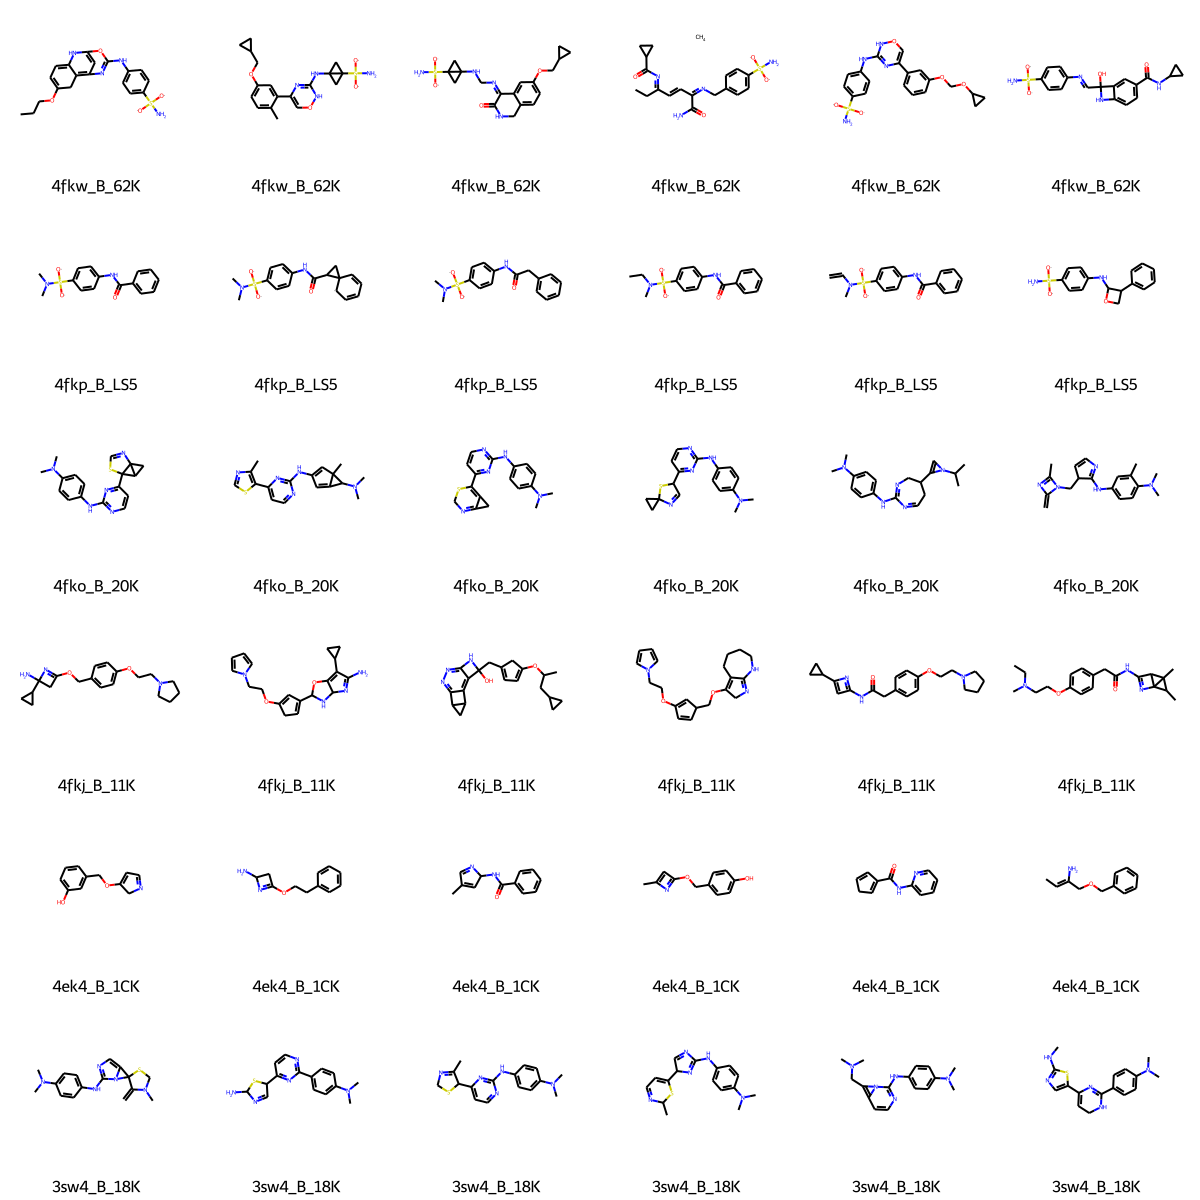

In [28]:
img = PandasTools.FrameToGridImage(
    df.drop_duplicates(subset=f"{blob}_fit_add_SMILES").sort_values(by=["lig_name",f"{blob}_fit_add_QED"], ascending=False).groupby("lig_name").head(6).reset_index(drop=True), 
    column=f"mol_{blob}", legendsCol=f"lig_name", molsPerRow=6, maxMols=60,
    returnPNG=False, # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [29]:
img.save(os.path.join("plots", prefix + "_topQED.png"))

### Distributions

#### RMSD

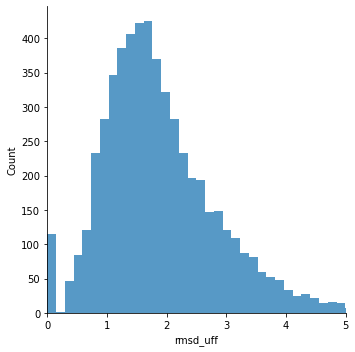

In [30]:
sns.displot(df["rmsd_uff"])
plt.xlim([0,5])
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.png"))

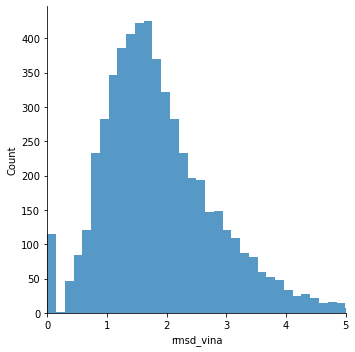

In [31]:
sns.displot(df["rmsd_vina"])
plt.xlim([0,5])
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.png"))

Systems with 0.0 RMSD UFF are systems for which the minimisation failed (the generated molecule is not minimied but the minimised output is nonetheless produced). Some failures are due to `Unrecognized charge state for atoms: #X` while other are not better specified `UFF Exception` problems.

#### QED

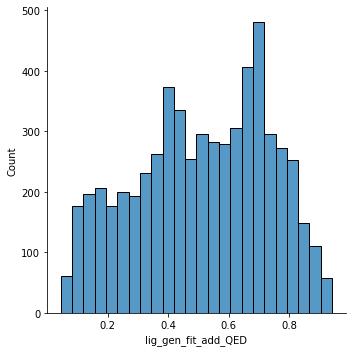

In [32]:
sns.displot(df[f"{blob}_fit_add_QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

#### Scores

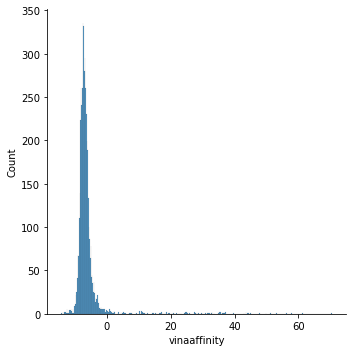

In [33]:
sns.displot(df[f"vinaaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distVina.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distVina.png"))

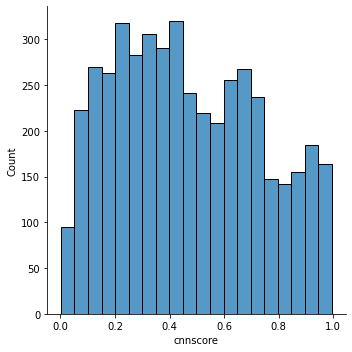

In [34]:
sns.displot(df["cnnscore"])
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.png"))

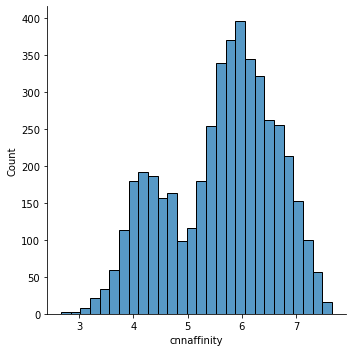

In [35]:
sns.displot(df["cnnaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.png"))

### Simple Statistics

In [36]:
rmsd_statistics(df, maxRMSD)

--- UFF ---
Average RMSD: 5.0714893970964985
Median RMSD: 1.78402
Percentage of low-RMSD samples: 11.989752348420152%
--- VINA ---
Average RMSD: 5.0714893970964985
Median RMSD: 1.78402
Percentage of low-RMSD samples: 11.989752348420152%


### Correlation

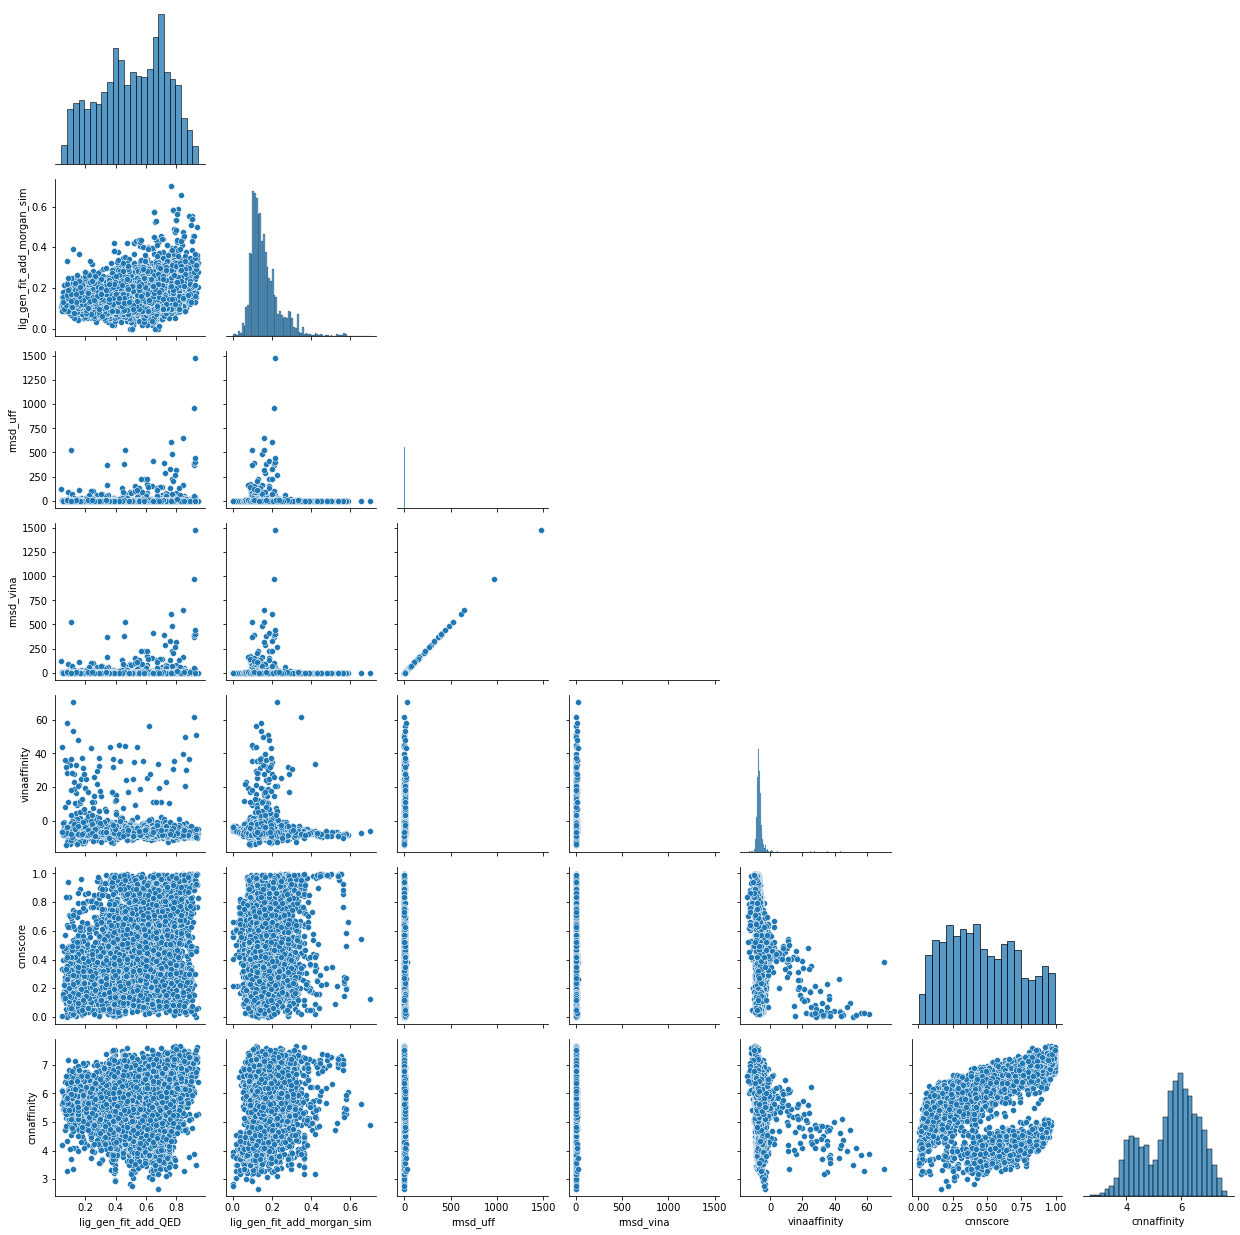

In [37]:
to_plot = [
    f"{blob}_fit_add_QED", f"{blob}_fit_add_morgan_sim", 
    "rmsd_uff", "rmsd_vina", 
    "vinaaffinity", "cnnscore", "cnnaffinity"
]

g = sns.PairGrid(df[to_plot], corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.savefig(os.path.join("plots", prefix + "_correlations.pdf"))
plt.savefig(os.path.join("plots", prefix + "_correlations.png"))

### Filter Molecules

In [38]:
df_filtered = filter(df, maxRMSD, minQED)

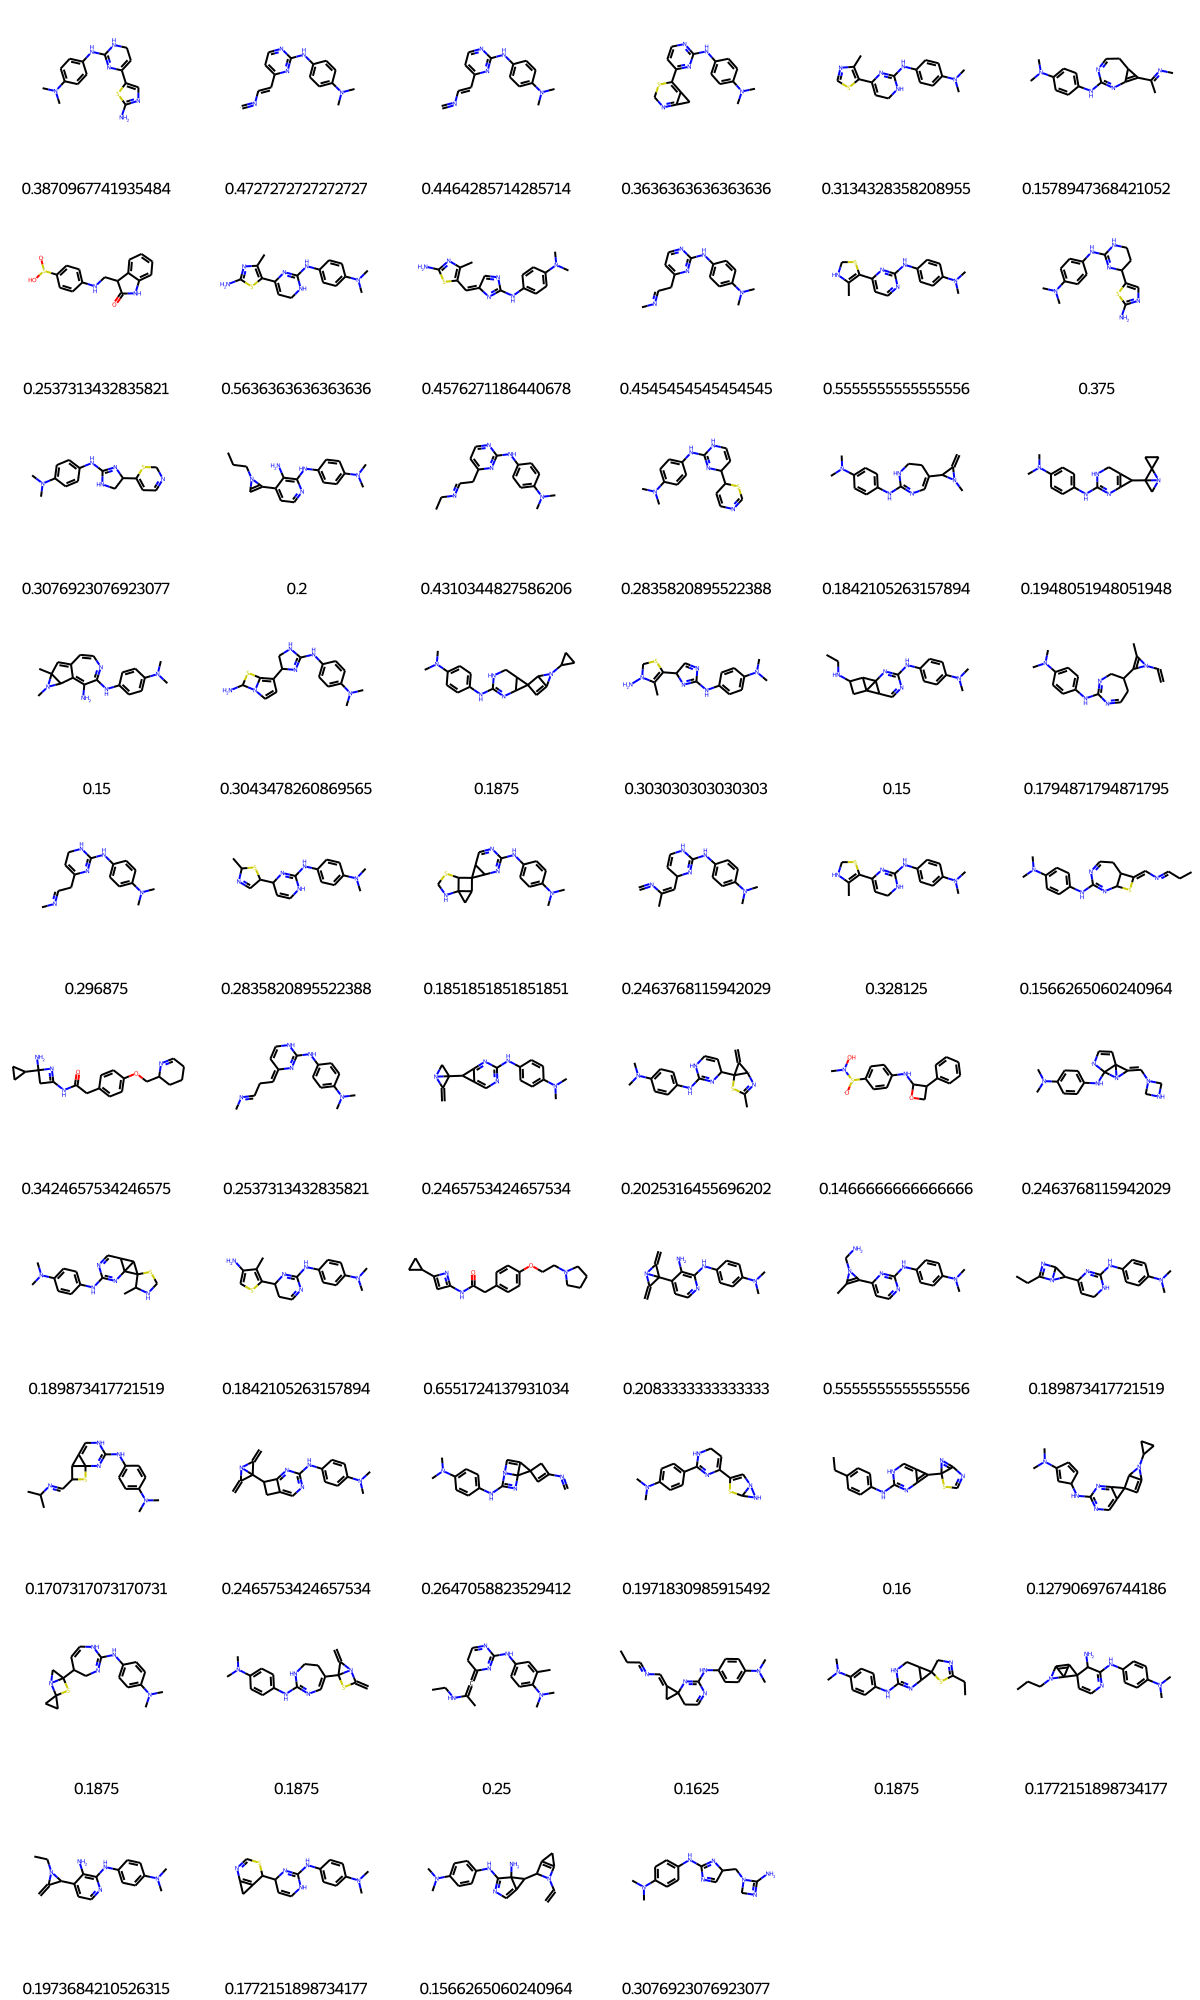

In [39]:
img = PandasTools.FrameToGridImage(
    df_filtered, 
    column=f"mol_{blob}", legendsCol=f"{blob}_fit_add_morgan_sim", molsPerRow=6, maxMols=np.inf,
    returnPNG=False, # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [40]:
img.save(os.path.join("plots", prefix + "_molfiltered.png"))

In [41]:
len(df_filtered)

58

In [42]:
dfcolumns = [
    "lig_name", "sample_idx", 
    "lig_gen_fit_add_morgan_sim", 
    "rmsd_uff", "rmsd_vina", 
    "vinaaffinity", 
    "cnnscore", "cnnaffinity",
    "mol_lig_gen"
]

,lig_name,sample_idx,lig_gen_fit_add_morgan_sim,rmsd_uff,rmsd_vina,vinaaffinity,cnnscore,cnnaffinity,mol_lig_gen
2300,3sw4_B_18K,300,0.387097,0.47474,0.47474,-7.98159,0.66203,6.51196,
2309,3sw4_B_18K,309,0.472727,0.47645,0.47645,-8.20968,0.99262,6.87639,
2007,3sw4_B_18K,7,0.446429,0.51902,0.51902,-8.25423,0.99412,6.91428,
3612,4fko_B_20K,612,0.363636,0.53689,0.53689,-9.98152,0.99360,7.61673,
3508,4fko_B_20K,508,0.313433,0.54717,0.54717,-8.98799,0.88361,7.08230,
3911,4fko_B_20K,911,0.157895,0.56120,0.56120,-9.64391,0.98935,7.22875,
2880,3sw4_B_18K,880,0.563636,0.62924,0.62924,-8.53463,0.76470,6.80775,
2421,3sw4_B_18K,421,0.457627,0.62991,0.62991,-9.49523,0.99364,7.39061,
2765,3sw4_B_18K,765,0.454545,0.65100,0.65100,-7.67315,0.99234,6.78463,
2587,3sw4_B_18K,587,0.555556,0.65844,0.65844,-9.26406,0.99436,7.29964,

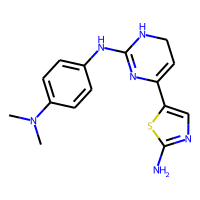
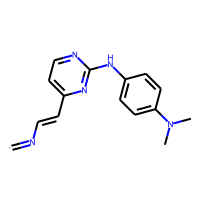
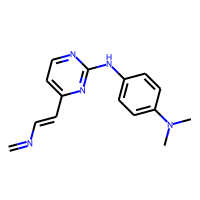
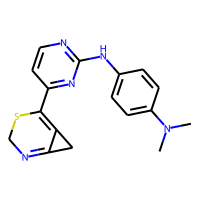
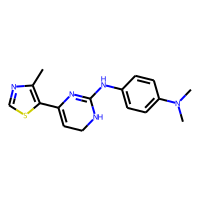
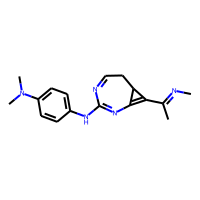
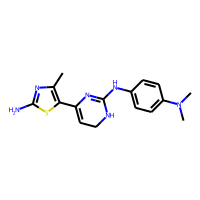
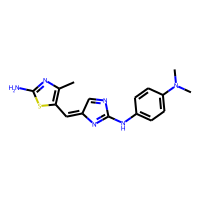
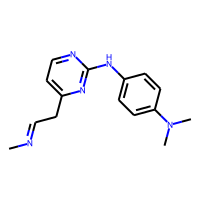
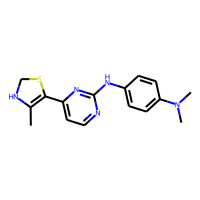
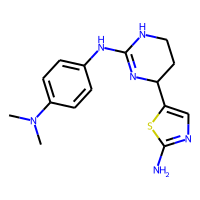
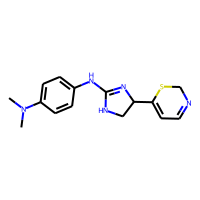
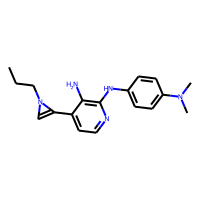
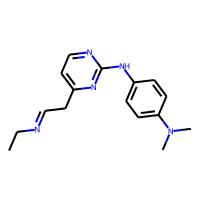
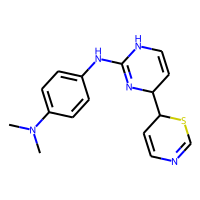
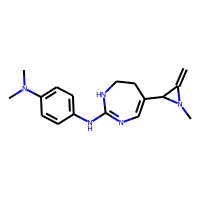
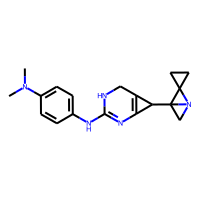
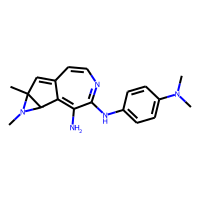
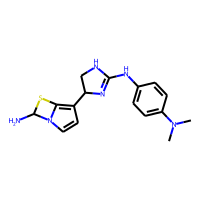
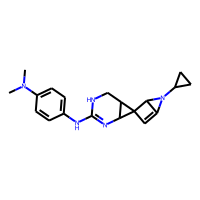
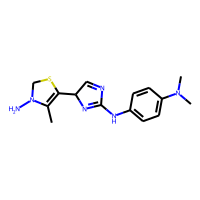
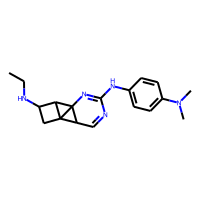
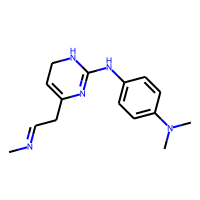
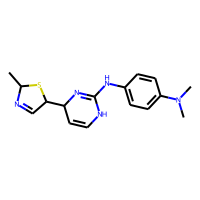
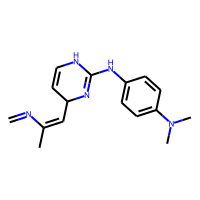
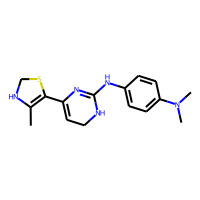
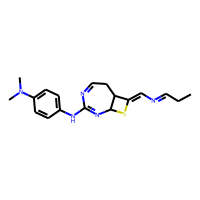
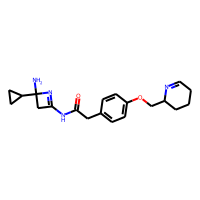
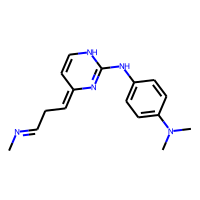
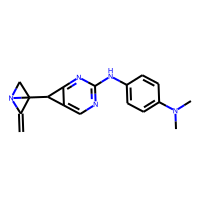
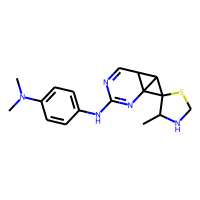
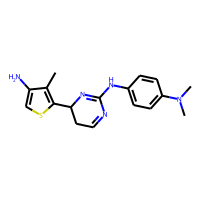
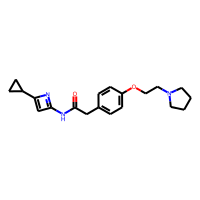
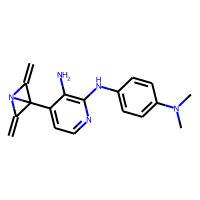
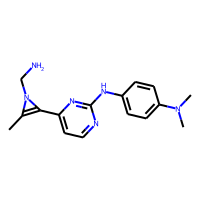
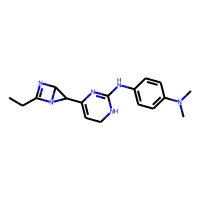
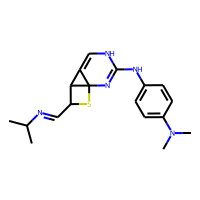
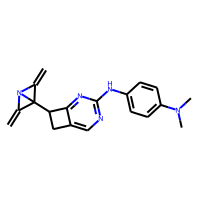
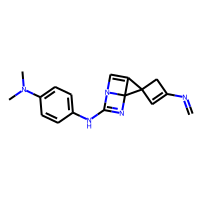
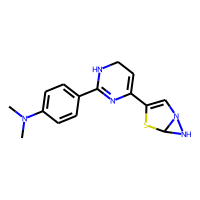
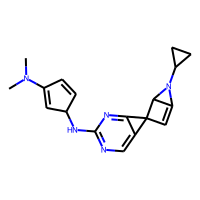
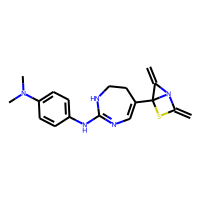
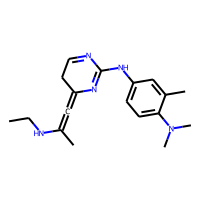
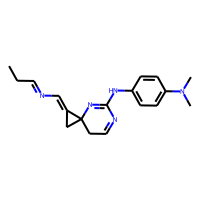
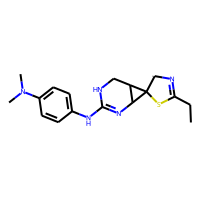
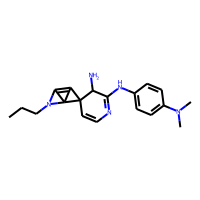
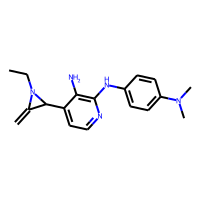
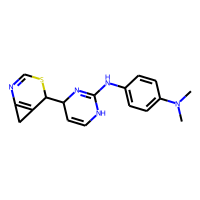
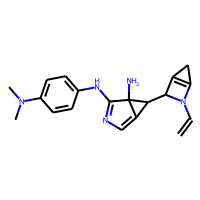
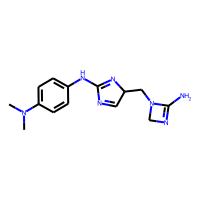

In [43]:
df_filtered[df_filtered.vinaaffinity < maxVina][dfcolumns]

,lig_name,sample_idx,lig_gen_fit_add_morgan_sim,rmsd_uff,rmsd_vina,vinaaffinity,cnnscore,cnnaffinity,mol_lig_gen
2309,3sw4_B_18K,309,0.472727,0.47645,0.47645,-8.20968,0.99262,6.87639,
2007,3sw4_B_18K,7,0.446429,0.51902,0.51902,-8.25423,0.99412,6.91428,
3612,4fko_B_20K,612,0.363636,0.53689,0.53689,-9.98152,0.99360,7.61673,
3508,4fko_B_20K,508,0.313433,0.54717,0.54717,-8.98799,0.88361,7.08230,
3911,4fko_B_20K,911,0.157895,0.56120,0.56120,-9.64391,0.98935,7.22875,
2880,3sw4_B_18K,880,0.563636,0.62924,0.62924,-8.53463,0.76470,6.80775,
2421,3sw4_B_18K,421,0.457627,0.62991,0.62991,-9.49523,0.99364,7.39061,
2765,3sw4_B_18K,765,0.454545,0.65100,0.65100,-7.67315,0.99234,6.78463,
2587,3sw4_B_18K,587,0.555556,0.65844,0.65844,-9.26406,0.99436,7.29964,
2631,3sw4_B_18K,631,0.375000,0.66309,0.66309,-8.18834,0.71932,6.61580,

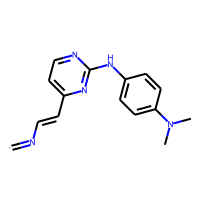
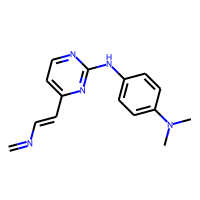
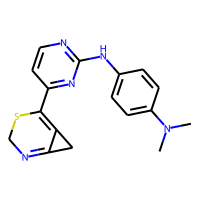
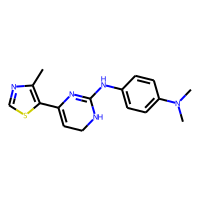
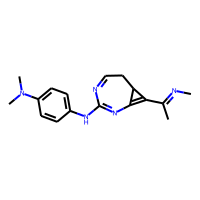
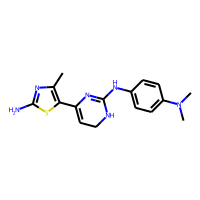
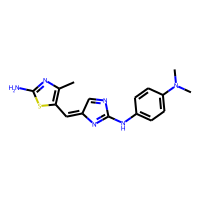
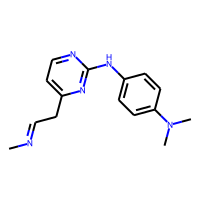
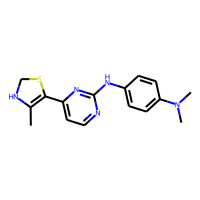
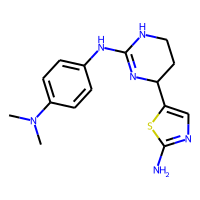
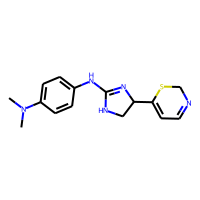
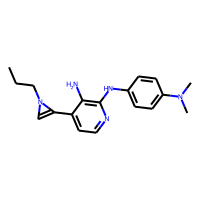
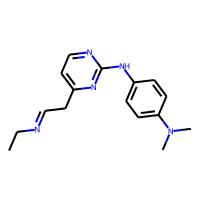
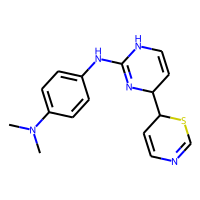
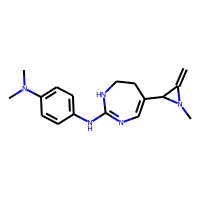
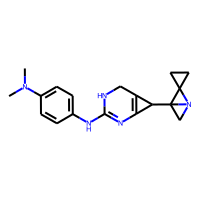
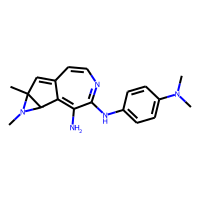
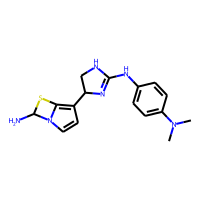
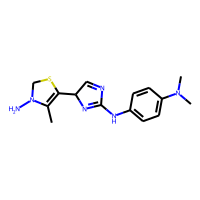
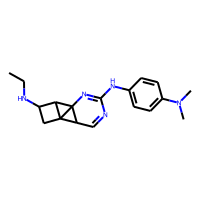
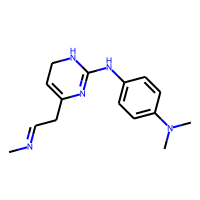
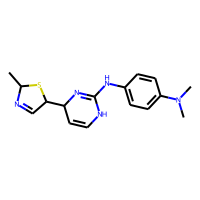
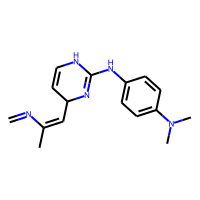
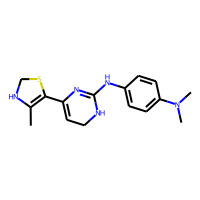
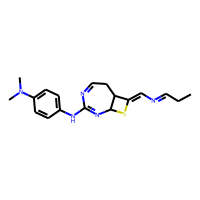
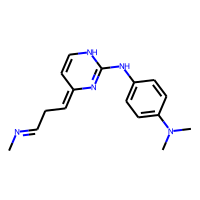
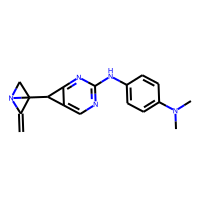
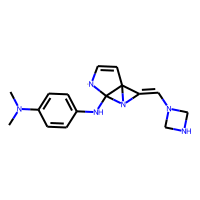
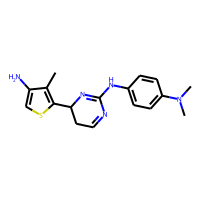
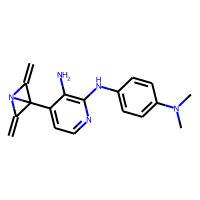
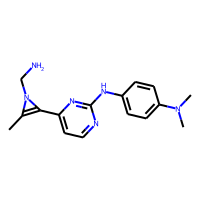
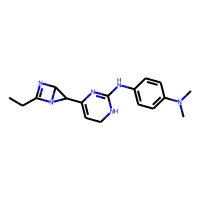
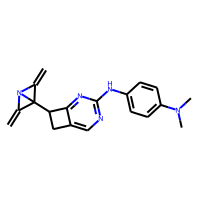
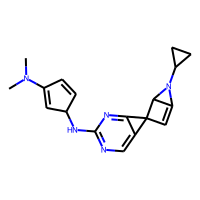
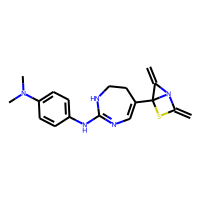
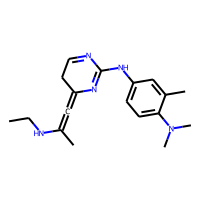
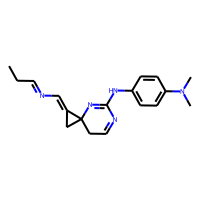
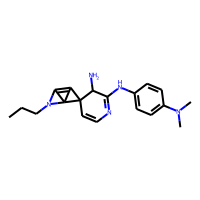
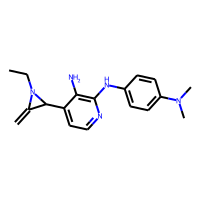
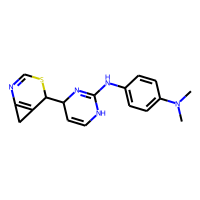
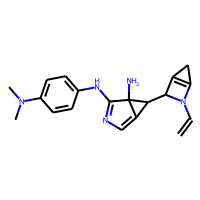
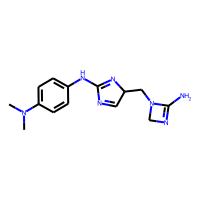

In [44]:
df_filtered[df_filtered.cnnscore > minCNNscore][dfcolumns]

## Variability Factor: 1.0

### Data

In [45]:
datafile = "generated/CDK2rec_vf1.0_big.gen_metrics"

In [46]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'CDK2rec_vf1.0_big'

In [47]:
df = pd.read_csv(datafile, sep=" ")
df.head()

,lig_name,sample_idx,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_L1_loss,lig_latent_norm,lig_latent_variance,...,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_min_time,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_ref,lig_gen_fit_add_min_dE_ref,lig_gen_fit_add_RMSD_ref,lig_gen_fit_add_min_RMSD_ref
0,4ek4_B_1CK,0,28.204449,NaN,28.101410,NaN,40.519375,903.353638,23.088066,NaN,...,270737.978359,62.857139,-270675.121220,NaN,0.032204,1.583738,270661.177327,-13.943893,NaN,NaN
1,4ek4_B_1CK,1,28.204449,NaN,29.384552,NaN,71.032852,1041.507690,22.347216,NaN,...,910.684075,16.703528,-893.980547,NaN,0.005231,0.573424,833.883044,-60.097503,NaN,NaN
2,4ek4_B_1CK,2,28.204449,NaN,26.777344,NaN,24.050730,790.700378,22.782385,NaN,...,2517.633715,16.703528,-2500.930187,NaN,0.005176,0.366808,2440.832684,-60.097503,NaN,NaN
3,4ek4_B_1CK,3,28.204449,NaN,27.133144,NaN,45.625935,938.919067,21.608486,NaN,...,1256.295703,15.850372,-1240.445331,NaN,0.006298,0.979296,1179.494672,-60.950659,NaN,NaN
4,4ek4_B_1CK,4,28.204449,NaN,27.749260,NaN,30.868773,872.034912,22.589069,NaN,...,637.573398,20.416846,-617.156551,NaN,0.007400,0.565751,560.772366,-56.384185,NaN,NaN


Load RMSD calculations (between generated and minimised structures) for each ligand:

In [48]:
load_rmsd(dataroot, prefix, df)

Successfully reconstructed molecules: 95.48%


In [49]:
load_scores(dataroot, prefix, df)

In [50]:
df[df.rmsd_uff > 10][["lig_name", "sample_idx", "rmsd_uff"]]

,lig_name,sample_idx,rmsd_uff
4009,4fkp_B_LS5,9,15.63924
4011,4fkp_B_LS5,11,16.65185
4023,4fkp_B_LS5,23,10.59394
4025,4fkp_B_LS5,25,371.00123
4044,4fkp_B_LS5,44,14.57189
...,...,...,...
5871,4fkw_B_62K,871,14.12087
5925,4fkw_B_62K,925,103.79881
5953,4fkw_B_62K,953,196.34607
5961,4fkw_B_62K,961,20.32258


### Distributions

#### RMSD

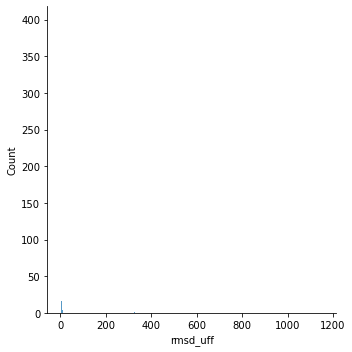

In [51]:
sns.displot(df["rmsd_uff"])
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.png"))

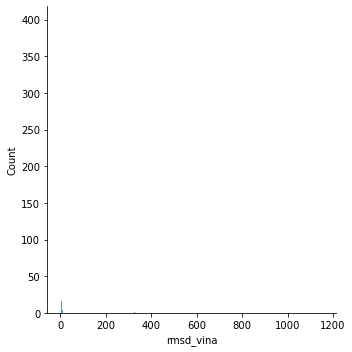

In [52]:
sns.displot(df["rmsd_vina"])
plt.savefig(os.path.join("plots", prefix + "_distRMSDvina.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDvina.png"))

#### QED

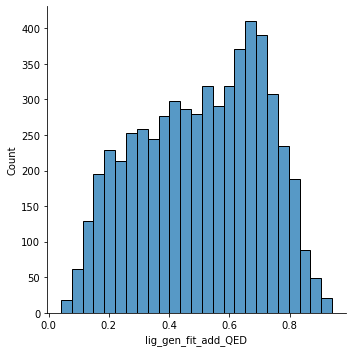

In [53]:
sns.displot(df[f"{blob}_fit_add_QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

#### Scores

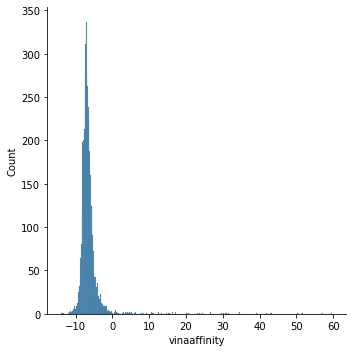

In [54]:
sns.displot(df[f"vinaaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distVina.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distVina.png"))

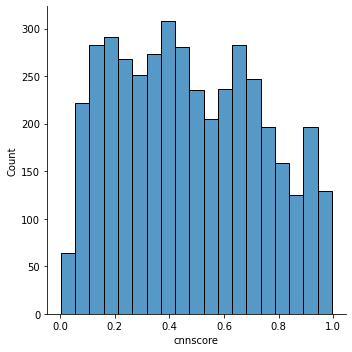

In [55]:
sns.displot(df["cnnscore"])
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.png"))

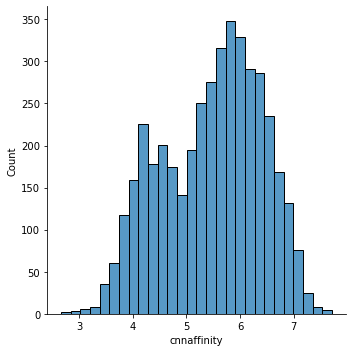

In [56]:
sns.displot(df["cnnaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.png"))

### Simple Statistics

In [57]:
rmsd_statistics(df, maxRMSD)

--- UFF ---
Average RMSD: 4.01838226566591
Median RMSD: 1.72645
Percentage of low-RMSD samples: 10.50794204922325%
--- VINA ---
Average RMSD: 4.01838226566591
Median RMSD: 1.72645
Percentage of low-RMSD samples: 10.50794204922325%


### Correlation

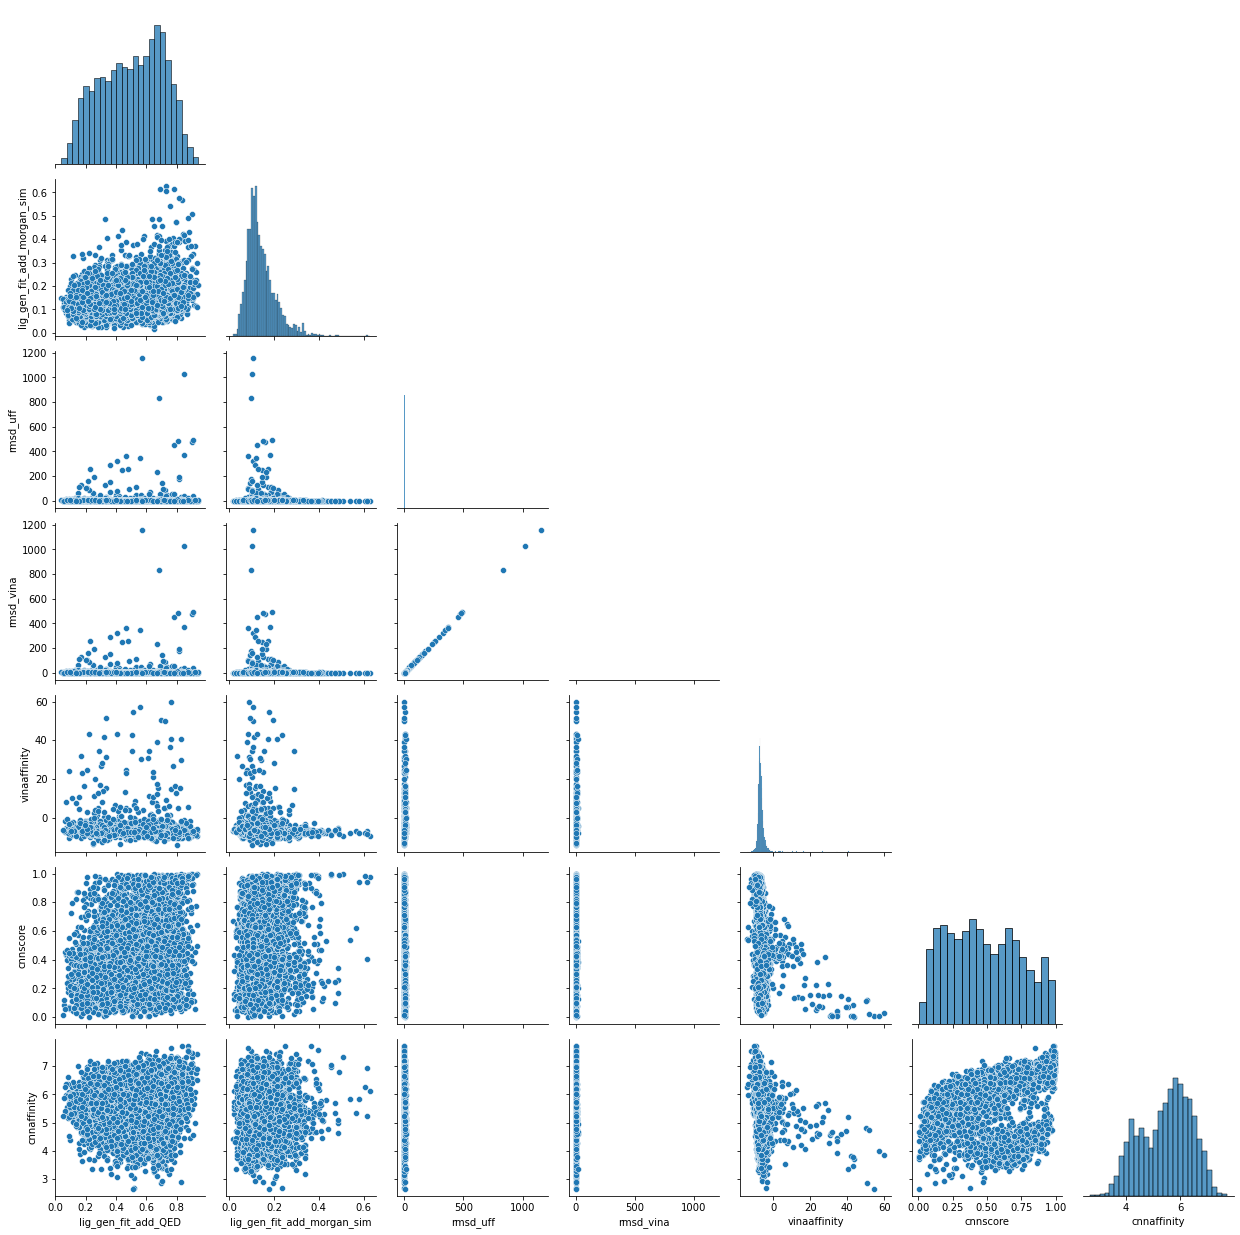

In [58]:
to_plot = [
    f"{blob}_fit_add_QED", f"{blob}_fit_add_morgan_sim", 
    "rmsd_uff", "rmsd_vina", 
    "vinaaffinity", "cnnscore", "cnnaffinity"
]

g = sns.PairGrid(df[to_plot], corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.savefig(os.path.join("plots", prefix + "_correlations.pdf"))
plt.savefig(os.path.join("plots", prefix + "_correlations.png"))

### Filter Molecules

In [59]:
df_filtered = filter(df, maxRMSD, minQED)

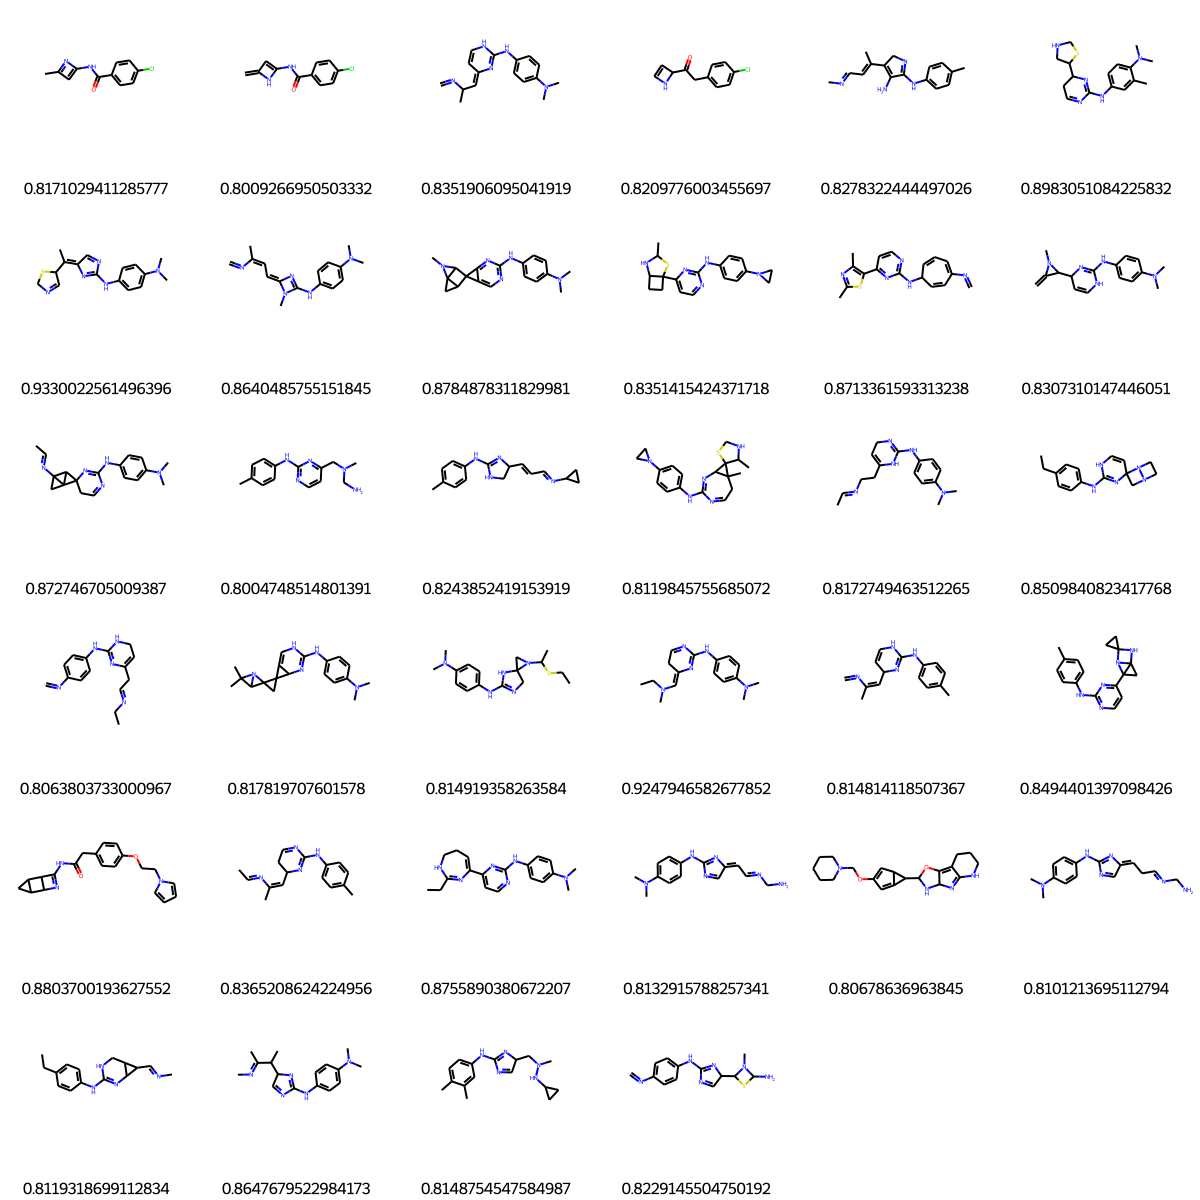

In [60]:
img = PandasTools.FrameToGridImage(
    df_filtered, 
    column=f"mol_{blob}", legendsCol="lig_gen_fit_add_QED", molsPerRow=6, maxMols=np.inf,
    returnPNG=False, # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [61]:
img.save(os.path.join("plots", prefix + "_molfiltered.png"))

In [62]:
len(df_filtered)

34

,lig_name,sample_idx,lig_gen_fit_add_morgan_sim,rmsd_uff,rmsd_vina,vinaaffinity,cnnscore,cnnaffinity,mol_lig_gen
274,4ek4_B_1CK,274,0.386364,0.41954,0.41954,-8.27788,0.87532,4.67556,
354,4ek4_B_1CK,354,0.326087,0.42078,0.42078,-8.21434,0.66788,4.41101,
3040,4fko_B_20K,40,0.171053,0.58371,0.58371,-8.57945,0.93279,6.85617,
961,4ek4_B_1CK,961,0.150943,0.58774,0.58774,-7.40670,0.57359,3.94957,
2473,3sw4_B_18K,473,0.202899,0.66626,0.66626,-8.05595,0.92954,6.74824,
3180,4fko_B_20K,180,0.273973,0.67531,0.67531,-8.70288,0.97162,7.11928,
2855,3sw4_B_18K,855,0.298507,0.69124,0.69124,-9.30449,0.99620,7.41276,
2301,3sw4_B_18K,301,0.253731,0.71226,0.71226,-7.99083,0.89595,6.49570,
3818,4fko_B_20K,818,0.226667,0.72679,0.72679,-10.35165,0.99103,7.50781,
3612,4fko_B_20K,612,0.250000,0.74865,0.74865,-10.41052,0.98177,7.71132,

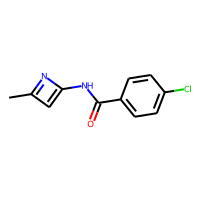
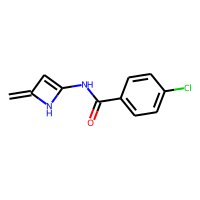
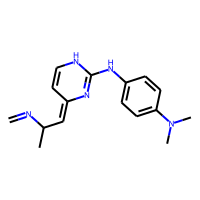
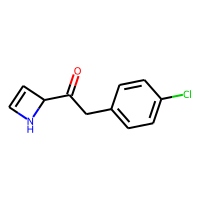
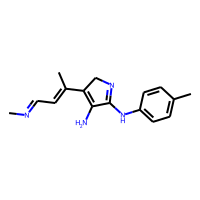
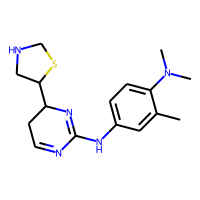
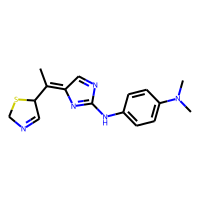
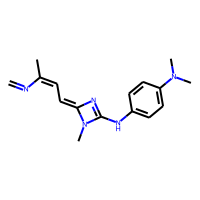
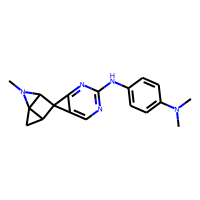
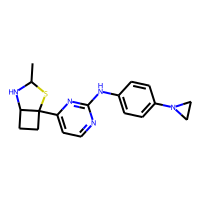
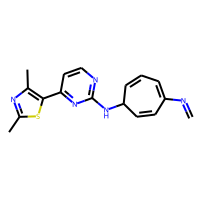
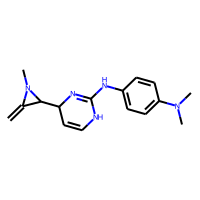
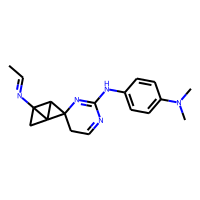
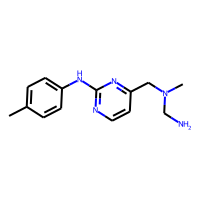
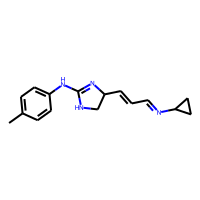
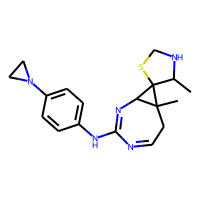
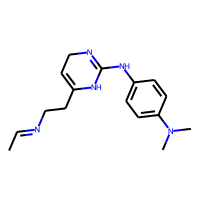
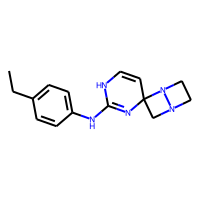
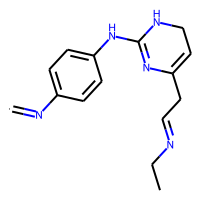
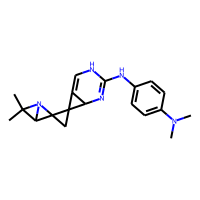
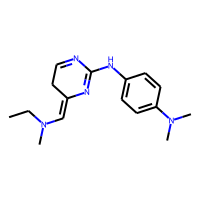
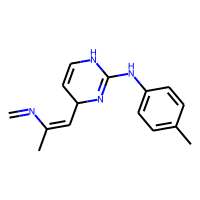
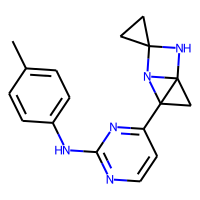
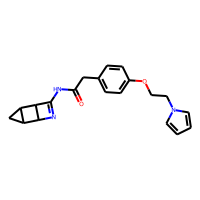
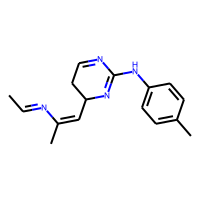
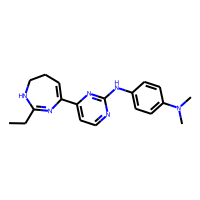
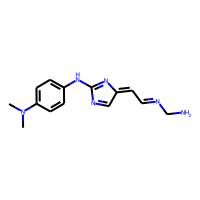
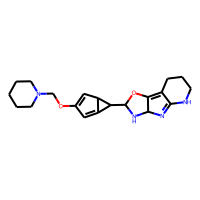
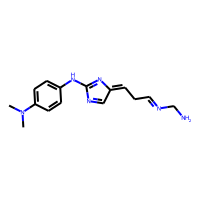
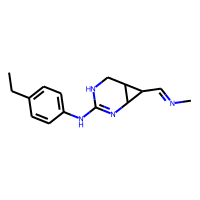
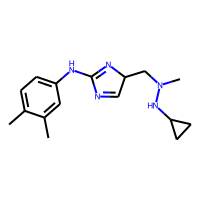

In [63]:
df_filtered[df_filtered.vinaaffinity < maxVina][dfcolumns]

In [64]:
print(len(df_filtered), len(df_filtered[df_filtered.vinaaffinity < maxVina][dfcolumns]))

34 31


,lig_name,sample_idx,lig_gen_fit_add_morgan_sim,rmsd_uff,rmsd_vina,vinaaffinity,cnnscore,cnnaffinity,mol_lig_gen
274,4ek4_B_1CK,274,0.386364,0.41954,0.41954,-8.27788,0.87532,4.67556,
3040,4fko_B_20K,40,0.171053,0.58371,0.58371,-8.57945,0.93279,6.85617,
2473,3sw4_B_18K,473,0.202899,0.66626,0.66626,-8.05595,0.92954,6.74824,
3180,4fko_B_20K,180,0.273973,0.67531,0.67531,-8.70288,0.97162,7.11928,
2855,3sw4_B_18K,855,0.298507,0.69124,0.69124,-9.30449,0.99620,7.41276,
2301,3sw4_B_18K,301,0.253731,0.71226,0.71226,-7.99083,0.89595,6.49570,
3818,4fko_B_20K,818,0.226667,0.72679,0.72679,-10.35165,0.99103,7.50781,
3612,4fko_B_20K,612,0.250000,0.74865,0.74865,-10.41052,0.98177,7.71132,
3340,4fko_B_20K,340,0.397059,0.75073,0.75073,-9.33993,0.96823,7.56457,
3732,4fko_B_20K,732,0.175676,0.78217,0.78217,-8.83988,0.91880,6.94039,

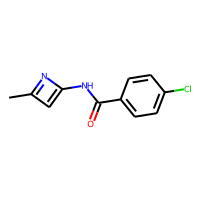
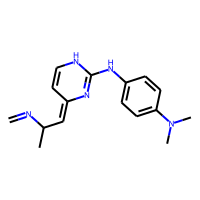
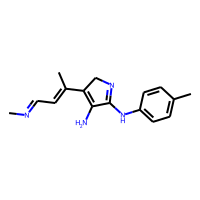
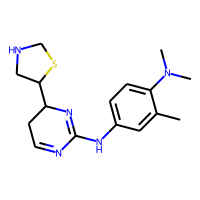
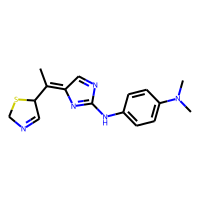
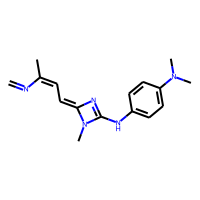
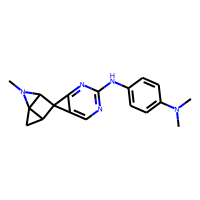
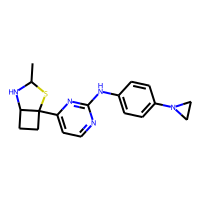
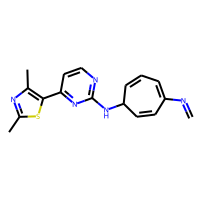
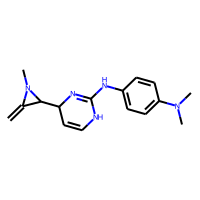
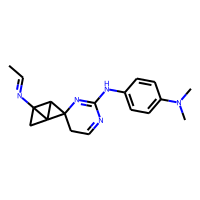
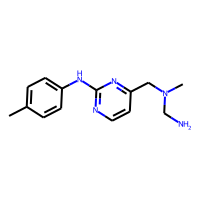
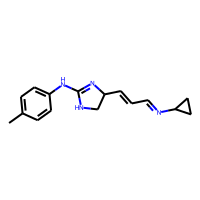
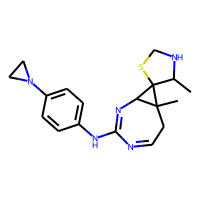
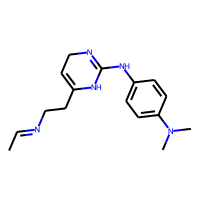
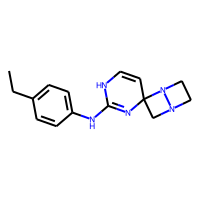
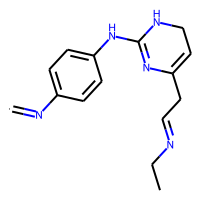
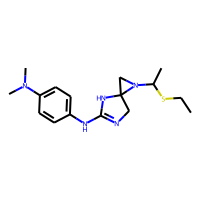
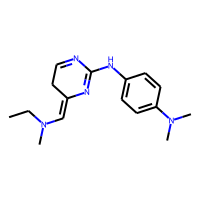
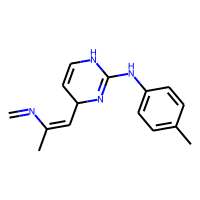
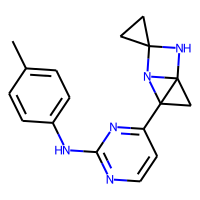
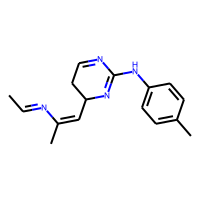
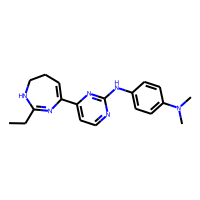
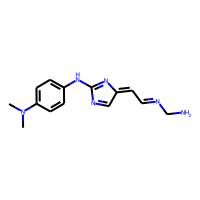
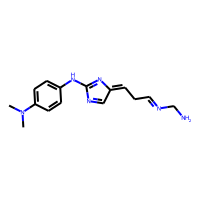
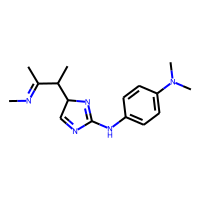
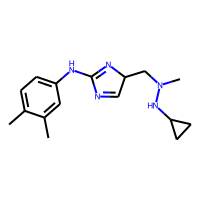

In [65]:
df_filtered[df_filtered.cnnscore > minCNNscore][dfcolumns]

In [66]:
print(len(df_filtered), len(df_filtered[df_filtered.cnnscore > minCNNscore][dfcolumns]))

34 27


## Variability Factor 5.0

### Data

In [67]:
datafile = "generated/CDK2rec_vf5.0_big.gen_metrics"

In [68]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'CDK2rec_vf5.0_big'

In [69]:
df = pd.read_csv(datafile, sep=" ")
df.head()

,lig_name,sample_idx,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_L1_loss,lig_latent_norm,lig_latent_variance,...,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_min_time,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_ref,lig_gen_fit_add_min_dE_ref,lig_gen_fit_add_RMSD_ref,lig_gen_fit_add_min_RMSD_ref
0,4ek4_B_1CK,0,28.204449,NaN,27.897810,NaN,329.280701,2748.909912,105.729324,NaN,...,3.895705e+03,417.527495,-3.478178e+03,NaN,0.005592,1.217760,3.818904e+03,340.726464,NaN,NaN
1,4ek4_B_1CK,1,28.204449,NaN,25.439016,NaN,423.314301,2953.233398,108.837769,NaN,...,8.644531e+03,120.373600,-8.524157e+03,NaN,0.008526,1.065508,8.567730e+03,43.572568,NaN,NaN
2,4ek4_B_1CK,2,28.204449,NaN,23.451931,NaN,500.444427,3105.894287,108.570259,NaN,...,2.559849e+03,62.743896,-2.497105e+03,NaN,0.017685,0.985630,2.483048e+03,-14.057135,NaN,NaN
3,4ek4_B_1CK,3,28.204449,NaN,26.108068,NaN,505.393188,2933.639160,107.412010,NaN,...,1.582967e+06,16.238951,-1.582951e+06,NaN,0.011610,1.297074,1.582891e+06,-60.562081,NaN,NaN
4,4ek4_B_1CK,4,28.204449,NaN,24.123123,NaN,400.866577,2890.631104,106.536285,NaN,...,2.641442e+04,311.916585,-2.610250e+04,NaN,0.016111,1.462334,2.633762e+04,235.115553,NaN,NaN


Load RMSD calculations (between generated and minimised structures) for each ligand:

In [70]:
load_rmsd(dataroot, prefix, df)

Successfully reconstructed molecules: 96.07%


In [71]:
load_scores(dataroot, prefix, df)

ValueError: shape mismatch: value array of shape (942,) could not be broadcast to indexing result of shape (940,)

In [ ]:
df[df.rmsd_uff > 10][["lig_name", "sample_idx", "rmsd_uff"]]

### Distributions

#### RMSD

In [ ]:
sns.displot(df["rmsd_uff"])
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.png"))

In [ ]:
sns.displot(df["rmsd_vina"])
plt.savefig(os.path.join("plots", prefix + "_distRMSDvina.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDvina.png"))

#### QED

In [ ]:
sns.displot(df[f"{blob}_fit_add_QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

#### Scores

In [ ]:
sns.displot(df[f"vinaaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distVina.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distVina.png"))

In [ ]:
sns.displot(df["cnnscore"])
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.png"))

In [ ]:
sns.displot(df["cnnaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.png"))

### Simple Statistics

In [ ]:
rmsd_statistics(df, maxRMSD)

### Correlation

In [ ]:
to_plot = [
    f"{blob}_fit_add_QED", f"{blob}_fit_add_morgan_sim", 
    "rmsd_uff", "rmsd_vina", 
    "vinaaffinity", "cnnscore", "cnnaffinity"
]

g = sns.PairGrid(df[to_plot], corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.savefig(os.path.join("plots", prefix + "_correlations.pdf"))
plt.savefig(os.path.join("plots", prefix + "_correlations.png"))

### Filter Molecules

In [ ]:
df_filtered = filter(df, maxRMSD, minQED)

In [ ]:
img = PandasTools.FrameToGridImage(
    df_filtered, 
    column=f"mol_{blob}", legendsCol="lig_gen_fit_add_QED", molsPerRow=6, maxMols=np.inf,
    returnPNG=False, # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [ ]:
img.save(os.path.join("plots", prefix + "_molfiltered.png"))

In [ ]:
len(df_filtered)

In [ ]:
df_filtered[df_filtered.vinaaffinity < maxVina][dfcolumns]

In [ ]:
print(len(df_filtered), len(df_filtered[df_filtered.vinaaffinity < maxVina][dfcolumns]))

In [ ]:
df_filtered[df_filtered.cnnscore > minCNNscore][dfcolumns]

In [ ]:
print(len(df_filtered), len(df_filtered[df_filtered.cnnscore > minCNNscore][dfcolumns]))